## Compute dry spells detected by ARC2
[ARC2](https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.FEWS/.Africa/.DAILY/.ARC2/.daily/.est_prcp/) is a data set of daily observed precipitation data that is updated relatively quickly compared to other data sets. 

This notebook retrieves the data, computes dry spells, and merges it with observed dry spells in the CHIRPS dataset in order to compare the two. 

TODO:
- Find a way to quickly incorporate new values, since computing on the whole dataset takes several hours

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import rioxarray
from shapely.geometry import mapping
import geopandas as gpd
import xarray as xr
import requests
import numpy as np
from rasterstats import zonal_stats
from datetime import timedelta

#### Set config values

In [7]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.raster_manipulation import invert_latlon, change_longitude_range

In [8]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration","drought")
dry_spells_processed_dir=os.path.join(country_data_processed_dir,"dry_spells")
chirpsgefs_processed_dir = os.path.join(dry_spells_processed_dir,"chirpsgefs")

#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
chirpsgefs_stats_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

### Download the data
Takes some time --> can better do this in a Python script

In [9]:
#only include coordinates that approximately cover MWI --> else waaaay huger
#TODO: make url flexible to include up to current date
arc2_mwi_url="https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.FEWS/.Africa/.DAILY/.ARC2/.daily/.est_prcp/T/%281%20Jan%202000%29%2830%20Mar%202021%29RANGEEDGES/X/%2832E%29%2836E%29RANGEEDGES/Y/%2820S%29%285S%29RANGEEDGES/data.nc"

In [ ]:
arc2_dir = os.path.join(drought_data_exploration_dir,"arc2")
# arc2_dir= "../../../Experiments/drought/Data/arc2"
Path(arc2_dir).mkdir(parents=True, exist_ok=True)
arc2_filepath = os.path.join(arc2_dir, "arc2_2000_2020_approxmwi.nc")
# strange things happen when just overwriting the file, so delete it first if it already exists
if os.path.exists(arc2_filepath):
    os.remove(arc2_filepath)

#have to authenticate by using a cookie
cookies = {
    '__dlauth_id': os.getenv("IRI_AUTH"),
}

# logger.info("Downloading arc2 NetCDF file. This might take some time")
response = requests.get(arc2_mwi_url, cookies=cookies, verify=False)

with open(arc2_filepath, "wb") as fd:
    for chunk in response.iter_content(chunk_size=128):
        fd.write(chunk)

woop


/Users/tinkavalentijn/.virtualenvs/antact_req/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iridl.ldeo.columbia.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [20]:
#open the data
ds=rioxarray.open_rasterio(os.path.join(drought_data_exploration_dir,"arc2","arc2_20002020_approxmwi.nc"),masked=True).squeeze()
#convert to dataset instead of datarray --> makes selection of variables easier
ds=ds.to_dataset()
#fix units attribute
ds.attrs["units"]='mm/day'

In [21]:
ds

<xarray.DataArray 'est_prcp' (T: 7760, y: 151, x: 41)>
[48042160 values with dtype=float64]
Coordinates:
  * T            (T) object 2000-01-01 12:00:00 ... 2021-03-30 12:00:00
  * y            (y) float64 -5.0 -5.1 -5.2 -5.3 ... -19.7 -19.8 -19.9 -20.0
  * x            (x) float64 32.0 32.1 32.2 32.3 32.4 ... 35.7 35.8 35.9 36.0
    spatial_ref  int64 0
Attributes:
    CE:             600
    colormap:       [16777215 16777215 16777184 15658671 16436871 16760576 [1...
    CS:             0
    description:    CPC/Africa Rainfall Climatology 2: Daily Values
    expires:        1617287700
    long_name:      Estimated Precipitation
    maxncolor:      254
    ncolor:         254
    pointwidth:     1
    scale_max:      600
    scale_min:      0
    standard_name:  lwe_precipitation_rate
    units:          ('mm/day', 'mm/day', 'mm/day', 'mm/day', 'mm/day', 'mm/da...
    scale_factor:   1.0
    add_offset:     0.0
    grid_mapping:   spatial_ref

In [23]:
#clip to MWI
df_bound=gpd.read_file(adm1_bound_path)
ds_clip=ds.rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

<AxesSubplot:title={'center':'T = 2021-03-28 12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

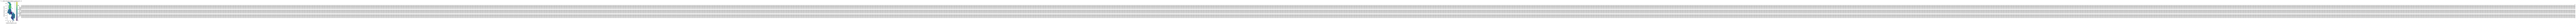

In [27]:
#simple plot
g=ds_clip.sel(T="2021-03-28").est_prcp.plot()
df_bound.boundary.plot(ax=g.axes)

In [29]:
#compute the 14 day rolling sum per cell
#window is to the right, inclusive
ds_rolling=ds_clip.rolling(T=14,min_periods=14).sum().dropna(dim="T",how="all")

In [71]:
#TODO: ARC2 has lower resolution than CHIRPS (0.1 vs 0.05)--> look into whether to use all cells touching instead of only center. Or possibly interpolating to higher resolution
def alldates_statistics(ds,raster_transform,adm_path,dim_col="est_prcp",ds_thresh_list=[2,4,8,10,15,20]):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.T.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(T=date)

        df["mean_cell"] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date[dim_col].values, affine=raster_transform, nodata=np.nan))["mean"]
        df["mean_cell_touched"] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date[dim_col].values, affine=raster_transform, nodata=np.nan,all_touched=True))["mean"]

        for thres in ds_thresh_list:
            # compute the percentage of the admin area that has cells below the threshold
            # set all values with below average rainfall to 1 and others to 0
            forecast_binary = np.where(ds_date[dim_col].values <= thres, 1, 0)
            # compute number of cells in admin region (sum) and number of cells in admin region with below average rainfall (count)
            bin_zonal = pd.DataFrame(
                zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, stats=['count', 'sum'],
                            nodata=np.nan))
            df[f'perc_se{thres}'] = bin_zonal['sum'] / bin_zonal['count'] * 100

            #         #same but then also including cells that only touch the admin region, i.e. don't have their cell within that region
            #         bin_zonal_touched = pd.DataFrame(
            #             zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, all_touched=True, stats=['count', 'sum'],nodata=np.nan))
            #         df['perc_threshold_touched'] = bin_zonal_touched['sum'] / bin_zonal_touched['count'] * 100

        
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
   
    # df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    # df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [73]:
# #only needed if not computed yet
# #This takes several hours --> better do it in a .py script
# #compute statistics on adm2 level per date
# df=alldates_statistics(ds_rolling,ds_rolling.rio.transform(),adm2_bound_path)
# df.drop("geometry",axis=1).to_csv(os.path.join(drought_data_exploration_dir,"arc2","mwi_arc2_precip_long.csv"))

2000-01-14 12:00:00
2000-01-15 12:00:00
2000-01-16 12:00:00
2000-01-17 12:00:00
2000-01-18 12:00:00
2000-01-19 12:00:00
2000-01-20 12:00:00
2000-01-21 12:00:00
2000-01-22 12:00:00
2000-01-23 12:00:00
2000-01-24 12:00:00
2000-01-25 12:00:00
2000-01-26 12:00:00
2000-01-27 12:00:00
2000-01-28 12:00:00
2000-01-29 12:00:00
2000-01-30 12:00:00
2000-01-31 12:00:00
2000-02-01 12:00:00
2000-02-02 12:00:00
2000-02-03 12:00:00
2000-02-04 12:00:00
2000-02-05 12:00:00
2000-02-06 12:00:00
2000-02-07 12:00:00
2000-02-08 12:00:00
2000-02-09 12:00:00
2000-02-10 12:00:00
2000-02-11 12:00:00
2000-02-12 12:00:00
2000-02-13 12:00:00
2000-02-14 12:00:00
2000-02-15 12:00:00
2000-02-16 12:00:00
2000-02-17 12:00:00
2000-02-18 12:00:00
2000-02-19 12:00:00
2000-02-20 12:00:00
2000-02-21 12:00:00
2000-02-22 12:00:00
2000-02-23 12:00:00
2000-02-24 12:00:00
2000-02-25 12:00:00
2000-02-26 12:00:00
2000-02-27 12:00:00
2000-02-28 12:00:00
2000-02-29 12:00:00
2000-03-01 12:00:00
2000-03-02 12:00:00
2000-03-03 12:00:00


In [14]:
#approx total number of days expected
21*365*32

245280

In [15]:
#load the above 
#only show column names, since this is quick to load, and full dataframe isn't
pd.read_csv(os.path.join(drought_data_exploration_dir,"arc2","mwi_arc2_precip_long.csv"),nrows=1)

,Unnamed: 0,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,...,validTo,geometry,mean_cell,mean_cell_touched,perc_se2,perc_se4,perc_se8,perc_se10,perc_se15,perc_se20
0,0,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,...,NaN,POLYGON ((35.20154234500006 -14.75810580599995...,39.308703,38.475286,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#load the data. Faster if only choosing a selection of columns
df=pd.read_csv(os.path.join(drought_data_exploration_dir,"arc2","mwi_arc2_precip_long.csv"),usecols=["date","ADM2_PCODE","mean_cell","perc_se2"])# ,nrows=10000)
df.date=pd.to_datetime(df.date)
df.rename(columns={"ADM2_PCODE":"pcode"},inplace=True)

In [17]:
df

,ADM2_PCODE,date,mean_cell,perc_se2
0,MW312,2000-01-14,39.308703,0.0
1,MW314,2000-01-14,NaN,NaN
2,MW303,2000-01-14,42.097829,0.0
3,MW307,2000-01-14,27.477241,0.0
4,MW205,2000-01-14,46.193182,0.0
...,...,...,...,...
245147,MW305,2021-03-30,62.277777,0.0
245148,MW312,2021-03-30,108.400793,0.0
245149,MW303,2021-03-30,96.219779,0.0
245150,MW301,2021-03-30,120.685184,0.0


In [18]:
# df.to_csv(os.path.join(drought_data_exploration_dir,"arc2","mwi_arc2_precip_long_sel.csv"))

In [ ]:
#define dry spells
df["dry_spell"]=np.where(df.mean_cell<=2,1,0)

In [29]:
#select only dates with dry spell
df_ds=df[df["dry_spell"]==1]
df_ds=df_ds.sort_values(["pcode","date"]).reset_index(drop=True)

In [38]:
#assign ID per consecutive sequence of dry spell days
df_ds["ID"]=df_ds.groupby("pcode").date.diff().dt.days.ne(1).cumsum()

In [54]:
#group the data, such to have one entry per dry spell, where the start and end date are indicated. 
df_ds_grouped=pd.DataFrame({'dry_spell_first_date' : df_ds.groupby('ID').date.first()-timedelta(days=13), 
              'dry_spell_last_date' : df_ds.groupby('ID').date.last(),
              'dry_spell_duration' : df_ds.groupby('ID').size()+13, 
              'dry_spell_confirmation' : df_ds.groupby('ID').date.first(),
              'pcode' : df_ds.groupby('ID').pcode.first()}).reset_index(drop=True)



In [55]:
df_ds_grouped

,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_confirmation,pcode
0,2000-04-16,2000-10-18,186,2000-04-29,MW101
1,2001-04-23,2001-05-20,28,2001-05-06,MW101
2,2001-05-23,2001-10-16,147,2001-06-05,MW101
3,2001-11-03,2001-11-17,15,2001-11-16,MW101
4,2002-04-21,2002-09-10,143,2002-05-04,MW101
...,...,...,...,...,...
1673,2019-06-05,2019-09-24,112,2019-06-18,MW315
1674,2019-10-11,2019-11-09,30,2019-10-24,MW315
1675,2020-02-25,2020-03-11,16,2020-03-09,MW315
1676,2020-03-28,2020-10-09,196,2020-04-10,MW315


In [56]:
# df_ds_grouped.to_csv(os.path.join(drought_data_exploration_dir,"arc2","mwi_arc2_dry_spells.csv"))

In [60]:
#add start year of the rainy season
df_ds_grouped["season_approx"]=np.where(df_ds_grouped.dry_spell_first_date.dt.month>=10,df_ds_grouped.dry_spell_first_date.dt.year,df_ds_grouped.dry_spell_first_date.dt.year-1)

In [61]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean_back.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [62]:
df_rain

,ID,pcode,ADM2_EN,season_approx,onset_date,onset_month,cessation_date,cessation_month,rainy_season_duration,rainy_season_rainfall
0,6.0,MW101,Chitipa,1999,NaT,NaN,2000-04-11,4.0,NaN,NaN
1,6.0,MW101,Chitipa,2000,2000-11-15,11.0,2001-04-03,4.0,140.0,1048.5
2,6.0,MW101,Chitipa,2001,2001-12-06,12.0,2002-04-21,4.0,137.0,1017.4
3,6.0,MW101,Chitipa,2002,2002-12-13,12.0,2003-04-12,4.0,121.0,903.0
4,6.0,MW101,Chitipa,2003,2003-12-02,12.0,2004-03-17,3.0,107.0,736.4
...,...,...,...,...,...,...,...,...,...,...
699,3.0,MW315,Blantyre City,2016,2016-11-23,11.0,2017-03-26,3.0,124.0,925.3
700,3.0,MW315,Blantyre City,2017,2017-11-13,11.0,2018-04-11,4.0,150.0,749.5
701,3.0,MW315,Blantyre City,2018,2018-11-24,11.0,2019-03-19,3.0,116.0,988.5
702,3.0,MW315,Blantyre City,2019,2019-11-24,11.0,2020-03-25,3.0,123.0,678.4


In [63]:
#add rainy season start and enddate to df
df_ds_grouped_raindates=df_ds_grouped.merge(df_rain[['pcode', 'season_approx', 'onset_date', 'cessation_date']], on = ['pcode', 'season_approx']) 

In [64]:
#compute whether date on which dry spell was confirmed, was within the rainy season
df_ds_grouped_raindates["during_rainy_season"]=np.where((df_ds_grouped_raindates.dry_spell_confirmation>=df_ds_grouped_raindates.onset_date)&(df_ds_grouped_raindates.dry_spell_confirmation<=df_ds_grouped_raindates.cessation_date),1,0)

In [65]:
#only select dry spells within rainy season
df_ds_rain=df_ds_grouped_raindates[df_ds_grouped_raindates.during_rainy_season==1]

In [66]:
len(df_ds_rain)

68

### Heatmap
Structure data such that it can be used for the R code to create a heatmap

In [68]:
#make list of all dates within a dry spell for arc2
#important to reset the index, since that is what is being joined on
df_ds_rain=df_ds_rain.reset_index(drop=True)
#create datetimeindex per row
a = [pd.date_range(*r, freq='D') for r in df_ds_rain[['dry_spell_first_date', 'dry_spell_last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_arc_daterange=df_ds_rain[["pcode"]].join(pd.DataFrame(a)).set_index(["pcode"]).stack().droplevel(-1).reset_index()
df_arc_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell, so add that information
df_arc_daterange["dry_spell_arc"]=1

In [72]:
#load chirps dry spells, since that is what we want to compare to
dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"dry_spells_during_rainy_season_list_2000_2020_mean_back.csv")
df_ds_chirps=pd.read_csv(dry_spells_list_path)
df_ds_chirps["dry_spell_first_date"]=pd.to_datetime(df_ds_chirps["dry_spell_first_date"])
df_ds_chirps["dry_spell_last_date"]=pd.to_datetime(df_ds_chirps["dry_spell_last_date"])
df_ds_chirps["year"]=df_ds_chirps.dry_spell_first_date.dt.year

#create df with all dates that were part of a dry spell per adm2
#important to reset the index, since that is what is being joined on
df_ds_chirps_res=df_ds_chirps.reset_index(drop=True)
#create datetimeindex per row
a = [pd.date_range(*r, freq='D') for r in df_ds_chirps_res[['dry_spell_first_date', 'dry_spell_last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_ds_chirps_daterange=df_ds_chirps_res[["pcode","ID_obs"]].join(pd.DataFrame(a)).set_index(["pcode","ID_obs"]).stack().droplevel(-1).reset_index()
df_ds_chirps_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell, so add that information
df_ds_chirps_daterange["dry_spell_chirps"]=1

In [74]:
#merge arc2 and chirps data
df_ds_both=df_arc_daterange.merge(df_ds_chirps_daterange,how="outer",on=["date","pcode"])
df_ds_both.dry_spell_chirps=df_ds_both.dry_spell_chirps.replace(np.nan,0)
df_ds_both.dry_spell_arc=df_ds_both.dry_spell_arc.replace(np.nan,0)
df_ds_both["season_approx"]=np.where(df_ds_both.date.dt.month>=10,df_ds_both.date.dt.year,df_ds_both.date.dt.year-1)

In [76]:
def label_ds(row):
    if row["dry_spell_chirps"]==1 and row["dry_spell_arc"]==1:
        return 3
    elif row["dry_spell_chirps"]==1:
        return 2
    elif row["dry_spell_arc"]==1:
        return 1
    else:
        return 0

In [77]:
#encode dry spells and whether both sources observed a dry spell, or only one of the two
df_ds_both["dryspell_match"]=df_ds_both.apply(lambda row:label_ds(row),axis=1)

In [78]:
#add dates that are not present in df_ds_both, i.e. outside rainy season
df_ds_both_filled=df_ds_both.sort_values('date').set_index(['date']).groupby('pcode').apply(lambda x: x.reindex(pd.date_range(pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2020'), name='date'),fill_value=0).drop('pcode',axis=1).reset_index()).reset_index().drop("level_1",axis=1)

In [79]:
#cause for now we only wanna show till end of 2020 cause no processed chirps data after that
df_ds_both_filled=df_ds_both_filled[df_ds_both_filled.date.dt.year<=2020]

In [80]:
df_ds_both_filled

,pcode,date,dry_spell_arc,ID_obs,dry_spell_chirps,season_approx,dryspell_match
0,MW103,2000-01-01,0.0,0.0,0.0,0,0
1,MW103,2000-01-02,0.0,0.0,0.0,0,0
2,MW103,2000-01-03,0.0,0.0,0.0,0,0
3,MW103,2000-01-04,0.0,0.0,0.0,0,0
4,MW103,2000-01-05,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...
138073,MW315,2020-12-27,0.0,0.0,0.0,0,0
138074,MW315,2020-12-28,0.0,0.0,0.0,0,0
138075,MW315,2020-12-29,0.0,0.0,0.0,0,0
138076,MW315,2020-12-30,0.0,0.0,0.0,0,0


In [81]:
df_ds_both_filled.to_csv(os.path.join(country_data_exploration_dir,"dryspells",f"dryspells_arc2_dates_viz_th2.csv"))

In [82]:
df_ds_rain.groupby("pcode").dry_spell_duration.mean()

pcode
MW103    100.500000
MW203     19.000000
MW205     26.000000
MW302     14.000000
MW303     14.000000
MW304     20.833333
MW305     24.200000
MW306     20.125000
MW307     17.333333
MW308     14.666667
MW309     15.000000
MW310     46.428571
MW311     23.166667
MW312     48.000000
MW313     28.250000
MW315     20.111111
Name: dry_spell_duration, dtype: float64

### Test with opendap
Which would be ideal, but failing due to not being able to get the packages right

this is a known issue due to NetCDF 1.5.5, see https://github.com/pydata/xarray/issues/4925. 
However, if I downgroad that in the requirements.txt to 1.5.1 the issue still persists
when using conda I do get the second example to work, but don't manage to correctly install geopandas, rioxarray and rasterio

In [11]:
def fix_calendar(ds, timevar='F'):
    """
    Some datasets come with a wrong calendar attribute that isn't recognized by xarray
    So map this attribute that can be read by xarray
    Args:
        ds (xarray dataset): dataset of interest
        timevar (str): variable that contains the time in ds

    Returns:
        ds (xarray dataset): modified dataset
    """
    if "calendar" in ds[timevar].attrs.keys():
        if ds[timevar].attrs['calendar'] == '360':
            ds[timevar].attrs['calendar'] = '360_day'
    elif "units" in ds[timevar].attrs.keys():
        if "months since" in ds[timevar].attrs['units']:
            ds[timevar].attrs['calendar'] = '360_day'
    return ds


In [12]:
arc2_url="https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.FEWS/.Africa/.DAILY/.ARC2/.daily/dods"

In [13]:
remote_data = xr.open_dataset(arc2_url,
                              decode_times=False)

In [14]:
remote_data

<xarray.Dataset>
Dimensions:   (T: 13970, X: 751, Y: 801)
Coordinates:
  * T         (T) float32 8.401e+03 8.402e+03 8.403e+03 ... 2.237e+04 2.237e+04
  * Y         (Y) float32 -40.0 -39.9 -39.8 -39.7 -39.6 ... 39.7 39.8 39.9 40.0
  * X         (X) float32 -20.0 -19.9 -19.8 -19.7 -19.6 ... 54.7 54.8 54.9 55.0
Data variables:
    est_prcp  (T, Y, X) float32 ...

In [15]:
remote_data.T.attrs["units"]='days since 1960-01-01 00:00:00 UTC'
remote_data.T.attrs['calendar'] = 'julian'#'360_day' #"julian"#

In [16]:
remote_data=remote_data.rename({"X":"lon","Y":"lat"})
remote_data=fix_calendar(remote_data,timevar="T")
remote_data = xr.decode_cf(remote_data)

In [17]:
remote_data

<xarray.Dataset>
Dimensions:   (T: 13970, lat: 801, lon: 751)
Coordinates:
  * T         (T) object 1983-01-01 00:00:00 ... 2021-03-31 00:00:00
  * lat       (lat) float32 -40.0 -39.9 -39.8 -39.7 ... 39.7 39.8 39.9 40.0
  * lon       (lon) float32 -20.0 -19.9 -19.8 -19.7 ... 54.7 54.8 54.9 55.0
Data variables:
    est_prcp  (T, lat, lon) float32 ...

In [18]:
df_bound=gpd.read_file(adm1_bound_path)

In [19]:
ds=remote_data.sel(T="2021-03-28").rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

KeyboardInterrupt: 

In [20]:
remote_data = xr.open_dataset("http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods",
                              decode_times=False)
tmax = remote_data["tmax"][:500, ::3, ::3]
tmax[0].plot()

RuntimeError: NetCDF: file not found